# Producing and Visualizing Sales Insights with Python

This project is an analysis of an AI generated E-commerce dataset to explore relationships between customer demographics, browsing behaivior, and online sales.

The dataset can be accessed at https://www.kaggle.com/datasets/samps74/e-commerce-customer-behavior-dataset.

This notebook includes a complete analysis, including observations, visualizations, and recommendations.

# 1. Data Preparation

In [1]:
# module / library imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pprint

# importing CSV data to DataFrame

df = pd.read_csv(r'/content/E-commerce.csv')

# overview of the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Customer ID       50 non-null     int64  
 1   Age               50 non-null     int64  
 2   Gender            50 non-null     object 
 3   Location          50 non-null     object 
 4   Annual Income     50 non-null     int64  
 5   Purchase History  50 non-null     object 
 6   Browsing History  50 non-null     object 
 7   Product Reviews   50 non-null     object 
 8   Time on Site      50 non-null     float64
dtypes: float64(1), int64(3), object(5)
memory usage: 3.6+ KB


In [2]:
# preview of the dataset

df.head()

,Customer ID,Age,Gender,Location,Annual Income,Purchase History,Browsing History,Product Reviews,Time on Site
0,1001,25,Female,City D,45000,"[{""Date"": ""2022-03-05"", ""Category"": ""Clothing""...","[{""Timestamp"": ""2022-03-10T14:30:00Z""}, {""Time...","Great pair of jeans, very comfortable. Rating:...",32.5
1,1001,32,Female,City D,65000,"[{""Product Category"": ""Clothing"", ""Purchase Da...","[{""Product Category"": ""Home & Garden"", ""Timest...",Great find! 5 stars,72.3
2,1002,32,Male,City A,50000,"[{'Purchase Date': '2022-02-15', 'Product Cate...",[{'Timestamp': '2022-05-12 16:15:00'}],"{""Review Text"": ""Good product, but could be ch...",75.0
3,1003,35,Other,City F,50000,"[{""Product Category"": ""Clothing"", ""Purchase Da...","[{""Product Category"": ""Home & Garden"", ""Timest...",The headphones are amazing! The sound quality ...,75.0
4,1001,32,Female,City D,55000,"[{""Product Category"": ""Electronics"", ""Purchase...","[{""Product Category"": ""Home & Garden"", ""Timest...","Great headphones, sound quality is amazing.",75.2


### Observations

* 'Purchase History' and 'Browsing History' columns contain complex data relationships within each cell. These must be transformed to make the nested data useful for exploratory analysis and otherwise.
* While the 'Customer ID' field is intended to represent unique customers, the age and timestamp data are not realistic or possible. For the sake of the project, I am ignoring that the nature of the data is impossible, but in a real business application, the source of the collection error would need to be identified.

# 2. Data Cleaning and Transformation

Note: before importation to pandas, square brackets were added, in columns purchase_history and browsing_history, to text strings beginning in curly braces in Excel such that calling the eval() function will always return lists to avoid having to write verbose type-handling code.

* The main focus of transforming the data will be populating other fields or examining data extracted from the JSON fields

In [3]:
# formatting column names to conform to naming conventions and remove any extra whitespace

df.columns = [column.strip().lower().replace(' ', '_') for column in df.columns]
df.columns


Index(['customer_id', 'age', 'gender', 'location', 'annual_income',
       'purchase_history', 'browsing_history', 'product_reviews',
       'time_on_site'],
      dtype='object')

In [4]:
# Convert strings in purchase_history and browsing_history columns to lists of dictionary objects to more easily access data in these columns

df['purchase_history'] = [eval(data) for data in df['purchase_history'].values.copy()]
df['browsing_history'] = [eval(data) for data in df['browsing_history'].values.copy()]

In [5]:
# Creating calculated fields to unpack purchase_history for exploratory analysis

df['num_purchases'] = df['purchase_history'].apply(len)

df['amount_spent'] = df['purchase_history'].apply(lambda x: round(sum([item['Price'] for item in x]), 2))

df.loc[ :5,['customer_id', 'num_purchases', 'amount_spent']]  # preview of the new fields

,customer_id,num_purchases,amount_spent
0,1001,3,194.97
1,1001,2,295.57
2,1002,2,284.99
3,1003,2,184.98
4,1001,1,249.99
5,1005,2,189.98


# 3. Exploratory analysis

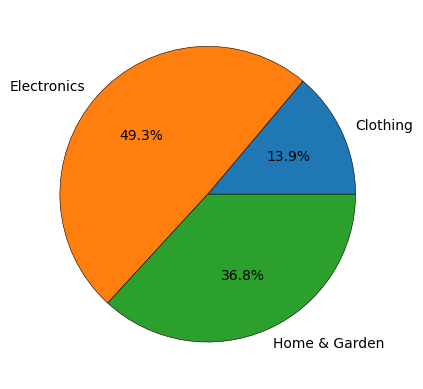

In [6]:
# obtaining sales category mix

category_amount_sums = {'Clothing': 0, 'Electronics': 0, 'Home & Garden': 0}

for purchases in df['purchase_history']:
  for purchase in purchases:
    if 'Category' in purchase.keys():
      purchase['Product Category']  = purchase['Category']
      del purchase['Category']
    category_amount_sums[purchase['Product Category']] += purchase['Price']

for key in category_amount_sums.keys():
  category_amount_sums[key] = round(category_amount_sums[key], 2)

# Plotting sales category mix

plt.pie(category_amount_sums.values(), labels=category_amount_sums.keys(), autopct='%.1f%%', wedgeprops={'linewidth': .4, 'edgecolor': 'black'})
plt.show()


In [7]:
# calculating sales directly attributable to instances of browsing history

def getAttributableSearchSales(browsing_history, purchase_history):
  """calculates sales directly attributable to searches.
     directly-attributable defined as purchase category matched to a browsed category where purchase date is later than browsing date)
  """
  sales_from_search = 0

  for search in browsing_history:
      if 'Product Category' in search.keys():
        search_category = search['Product Category']
        search_date = pd.to_datetime(search['Timestamp']).date()

        for purchase in purchase_history:
          if 'Date' in purchase.keys():
            purchase['Purchase Date']  = purchase['Date']
            del purchase['Date']

          purchase_category = purchase['Product Category']
          purchase_date = pd.to_datetime(purchase['Purchase Date']).date()
          purchase_amount = purchase['Price']

          if search_category == purchase_category and search_date < purchase_date:
            sales_from_search += purchase_amount

  if sales_from_search == 0:
    return pd.NA
  else:
    return sales_from_search

df['directly_attributable_sales'] = df.apply(lambda row: getAttributableSearchSales(row.loc['browsing_history'], row.loc['purchase_history']), axis=1)
df.loc[pd.notna(df['directly_attributable_sales'])]


,customer_id,age,gender,location,annual_income,purchase_history,browsing_history,product_reviews,time_on_site,num_purchases,amount_spent,directly_attributable_sales
5,1005,24,Male,City H,45000,"[{'Product Category': 'Electronics', 'Purchase...","[{'Product Category': 'Clothing', 'Timestamp':...",The laptop is perfect for my needs. It's light...,100.0,2,189.98,129.99
25,1002,42,Male,City E,75000,"[{'Product Category': 'Clothing', 'Purchase Da...","[{'Product Category': 'Electronics', 'Timestam...",The product arrived quickly and in great condi...,246.9,2,600.20,150.2
30,1002,42,Male,City E,80000,"[{'Product Category': 'Electronics', 'Purchase...","[{'Product Category': 'Clothing', 'Timestamp':...",I'm really happy with my new phone. The batter...,250.0,2,379.98,249.99
38,1004,52,Female,City G,100000,"[{'Product Category': 'Clothing', 'Purchase Da...","[{'Product Category': 'Electronics', 'Timestam...",I love my new kitchen gadget! It's so efficien...,300.0,2,479.98,79.99


## Observations

* only 4 of the 50 records contained 'directly attributable sales', revealing gaps in  data collection. This is likely not useful for generating insights.
* Next steps: in the following section, relationships will be examined. The 'time_on_site' data may be more valuable in identifying a potential relationship between browsing behaivior and sales.


# 4. Identifying relationships

Goals:
* identify any relationships that indicate a corelation with sales performance.
* produce summary statistics to break down sales by demographic

The following relationships with amount_spent will be investigated:
* time_on_site
* annual_income



In [8]:
# using groupby() to produce aggregate means for each customer's key metrics; storing it in a new DataFrame

cust_metrics = pd.DataFrame(df.groupby('customer_id').agg({'annual_income': 'mean', 'amount_spent': 'mean', 'time_on_site': 'mean'}))

cust_metrics.columns = ['mean_' + x for x in cust_metrics.columns]  # renaming columns to include statistic measured

cust_metrics.head()


,mean_annual_income,mean_amount_spent,mean_time_on_site
customer_id,,,
1001,58500.0,308.603333,123.437500
1002,69500.0,504.695000,239.466667
1003,64400.0,381.276000,242.260000
1004,68750.0,407.867500,294.625000
1005,63750.0,416.667500,222.450000


Text(0, 0.5, 'Mean Spending ($)')

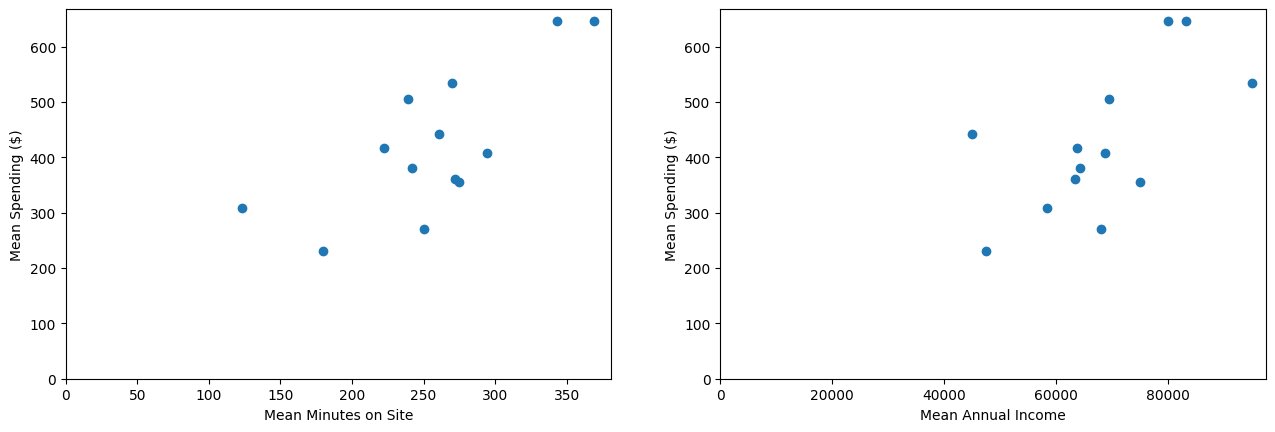

In [9]:
# Visualizing the relationship between averages

fig, axes = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.2, right=2.0)
time_plot = axes[0]
time_plot.scatter(cust_metrics['mean_time_on_site'], cust_metrics['mean_amount_spent'])
time_plot.set_ylim(ymin=0)
time_plot.set_xlim(xmin=0)
time_plot.set_xlabel('Mean Minutes on Site')
time_plot.set_ylabel('Mean Spending ($)')

sales_plot = axes[1]
sales_plot.scatter(cust_metrics['mean_annual_income'], cust_metrics['mean_amount_spent'])
sales_plot.set_ylim(ymin=0)
sales_plot.set_xlim(xmin=0)
sales_plot.set_xlabel('Mean Annual Income')
sales_plot.set_ylabel('Mean Spending ($)')




## Observations

* Both time on time on site and annual income appear to be positively corelated with mean spending per transaction
* A significant portion of the sample's mean incomes fall within the 40,000 to 70,000 range. Income groups may be a more useful way to aggregate total data for better insight.

In [10]:
# Adding income group columns to dataframe

df['income_group'] = pd.cut(df['annual_income'], 4)

income_group_spending = df.groupby('income_group', observed=True)[['amount_spent', 'num_purchases']].sum()
income_group_spending

,amount_spent,num_purchases
income_group,,
"(39940.0, 55000.0]",5541.94,42
"(55000.0, 70000.0]",4787.63,27
"(70000.0, 85000.0]",6211.65,26
"(85000.0, 100000.0]",4191.37,16


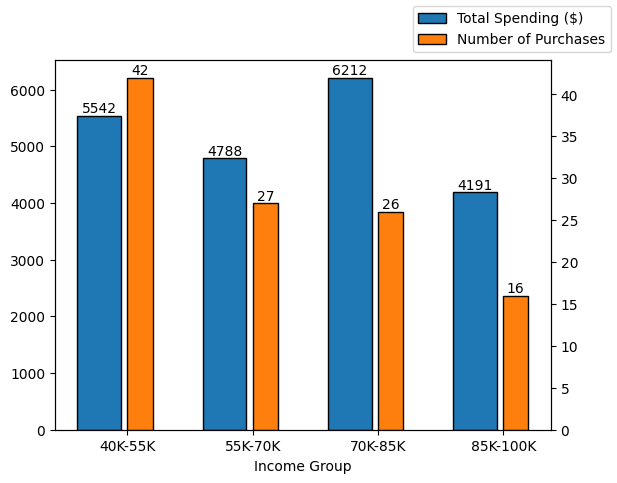

In [11]:
# Plotting each income group's total sales and number of purchases
fig, ax1 = plt.subplots()

tick_label = ['40K-55K', '55K-70K', '70K-85K', '85K-100K']

bars1 = ax1.bar(np.arange(len(income_group_spending.index.to_list())) - 0.2, round(income_group_spending['amount_spent']), width=.35, color='tab:blue', align='edge', edgecolor='black', linewidth=1)
ax1.bar_label(bars1)
ax1.set_xlabel('Income Group')

ax2 = ax1.twinx()
bars2 = ax2.bar(np.arange(len(income_group_spending.index.to_list())) + 0.2, income_group_spending['num_purchases'], width=.2, color='tab:orange', align='edge', tick_label=tick_label, edgecolor='black', linewidth=1)
ax2.bar_label(bars2)

fig.legend([bars1, bars2], ['Total Spending ($)', 'Number of Purchases'])

plt.show()

### Observations

* When comparing total sales and total purchase counts accross income groups, the lowest income group spent the least per transaction \(mean \$135.95), and the hightest income group spent the most per transaction \(mean \$261.94). While the 40K-55K income group produces the lowest mean revenue per transaction, they're total sales is second highest.
* The income group responsible for the hightest sales is in the 70K-85K range

# 6. Other demographic Breakdowns

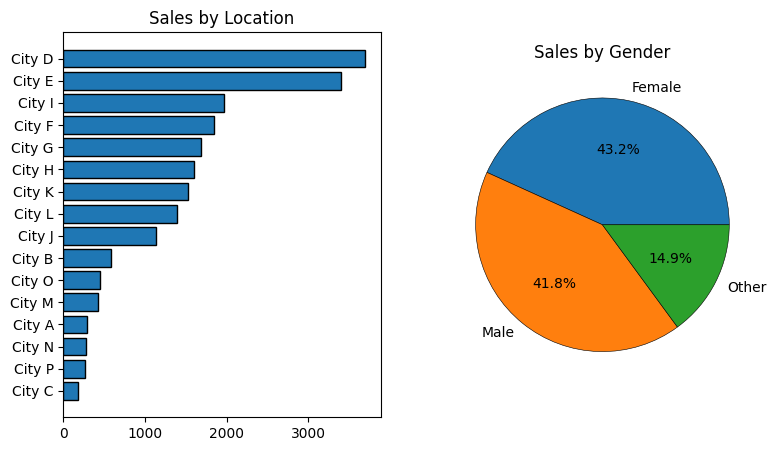

In [12]:
# calculating and visualizing aggregate sales sums for each location and gender

by_location = pd.DataFrame(df.groupby('location')['amount_spent'].sum()).sort_values('amount_spent', ascending=True)
by_gender = pd.DataFrame(df.groupby('gender')['amount_spent'].sum()).sort_values('amount_spent', ascending=False)

fig, (location_chart, gender_chart) = plt.subplots(1, 2, figsize=(9, 5))
plt.subplots_adjust(wspace=0.2)

gender_chart.pie(by_gender['amount_spent'], labels=by_gender.index.to_list(), autopct='%1.1f%%',  wedgeprops={'linewidth': 0.4, 'edgecolor': 'black'})
gender_chart.set_title('Sales by Gender')

location_chart.barh(by_location.index.to_list(), width=by_location['amount_spent'], edgecolor='black', linewidth=1)
location_chart.set_title('Sales by Location')



plt.show()


In [13]:
# obtaining city sales percentages of whole

by_location['percent_of_total'] = by_location['amount_spent'] / by_location['amount_spent'].sum() * 100
by_location.sort_values('percent_of_total', ascending=False).head()


,amount_spent,percent_of_total
location,,
City D,3703.24,17.861927
City E,3403.17,16.414592
City I,1966.90,9.486996
City F,1846.38,8.905689
City G,1681.47,8.110275


# Final Observations and Summary

* A positive corelation exists between mean time on site and mean sales per customer.

* A positive corelation exists between mean annual income and mean sales per customer.

* Users who spend less than an average of 220 minutes on the site when browsing
 spend significatly less than those who spend more than 220 minutes.

 * The minimum amount of time spent browsing which produced a sales was 32.5 minutes.

* Cities D and E make up 16.41% and 17.86% of sales, respectively. The next highest sales city makes up 9.49% of sales.

* Of the 3 product categories, clothing makes up only 13.9% of total revenue.

# Recommendations

Assuming these 50 records among 13 individuals accurately represent the customer population:

1. Incentivise longer browsing periods with a goal of an average browsing period above 220 minutes per customer.

2. Ensure logistics and distribution avenues are optimized for orders shipped to cities D and E to avoid high shipping costs and high volumes of late or incorrect deliveries.

3. With clothing composing 13.9% of the 3 product categories' sales, there may be an opportunity to increase revenues by reassessing consumer needs and inventory pricing.

4. Improve data collection such that browsing records contain category and item information to explore behaivioral insights

# Opportunities for further exploration

1. To confirm the validity of the findings, a larger dataset may be more useful. The sample containing only 13 individuals is not likely to produce reliable insights for the larger customer base.

2. To produce insights to increase efficiency in targeted advertising,  granular data regarding the products within each category being browsed and sold could be analyzed. These data would also support recommendation 3 by producing insights about clothing products' performance.